## `Initial Setup`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik

import warnings
warnings.filterwarnings('ignore')

## `Contents`

1. Business Understanding
2. Data Understanding
3. Data Preprocessing
4. Modeling
5. Conclusion
6. Recommendation

## `1. Business Understanding`

### **1.1 Context**

Banyak kota di berbagai wilayah dunia sudah menerapkan sistem bike-sharing sebagai salah satu solusi masalah kepadatan lalu-lintas yaitu kemacetan, dan upaya untuk menurunkan emisi gas karbon yang berasal dari penggunaan kendaraan pribadi. Bike-sharing adalah sistem dimana sepeda disediakan oleh suatu instansi di berbagai titik lokasi dalam satu kota untuk dapat disewa oleh publik dalam jangka waktu tertentu, biasanya hitungan menit hingga jam dalam satu hari dan untuk jarak tempuh pendek. Melalui sistem bike-sharing, masyarakat didorong untuk mengurangi penggunaan kendaraan pribadi dengan beralih ke transportasi ramah lingkungan. Salah satu kota yang menerapkan sistem ini adalah Washington DC, ibukota Amerika Serikat. 

Capital Bikeshare merupakan sistem docked bike-sharing di Washington DC yang dimiliki oleh pemerintah setempat. Docked bike-sharing mempunyai sistem penyimpanan sepeda yang 'terkunci' di lokasi yang sudah ditentukan (disebut juga stasiun). Pengguna yang ingin menyewa sepeda dapat membuka kunci sepeda di stasiun keberangkatan dan memarkir sepeda di stasiun tujuan dengan mengunci kembali sepeda pada tempatnya. Mulai beroperasi pada September 2010 dengan meluncurkan 400 sepeda di 49 stasiun, Capital Bikeshare menjadi sistem bike-sharing terbesar di Amerika Serikat sampai tahun 2013. Motivator LLC merupakan kontraktor yang mengelola operasional Capital Bikeshare, mulai dari suplai ketersediaan sepeda hingga perawatan dan perbaikan sepeda.

### **1.2 Problem Statement**

Salah satu komponen penting yang menentukan kesuksesan bike-sharing adalah keseimbangan antara jumlah sepeda yang tersedia (supply) dengan jumlah pengguna sepeda (demand) pada setiap kondisi. Jika jumlah sepeda lebih sedikit dari kebutuhan, maka sistem dapat kehilangan pengguna atau pelanggan. Sebaliknya, jika jumlah sepeda lebih banyak dari jumlah pengguna, sistem menjadi tidak efisien dan dapat menambah biaya operasional hingga perawatan sepeda yang seharusnya bisa tidak perlu dikeluarkan.

### **1.3 Goals**

Dari permasalahan di atas, dengan mengetahui jumlah pengguna sepeda pada kondisi tertentu akan membantu stakeholder terkait yaitu penyedia sepeda (atau dalam konteks ini adalah kontraktor operasional Capital Bikeshare) dalam menentukan suplai sepeda. Jumlah pengguna sepeda ingin diprediksi seakurat mungkin atau mempunyai nilai error prediksi yang sekecil mungkin agar stakeholder dapat mengalokasikan jumlah sepeda tepat dengan kebutuhan sehingga tidak menghilangkan jumlah pengguna maupun menambahkan biaya operasional yang tidak perlu.

### **1.4 Analytic Approach**

Analisis data dilakukan untuk menemukan pola dan membangun model regresi yang dapat memprediksi jumlah pengguna sepeda berdasarkan kondisi suatu hari. Kita akan melihat apakah penggunaan sepeda dipengaruhi oleh cuaca dan musim, dan jika iya, bagaimana cuaca dan musim mempengaruhi penggunaan sepeda.

### **1.5 Metric Evaluation**

Metrik yang digunakan untuk mengevaluasi model adalah:
* (1) Mean Absolute Error (MAE), atau rerata dari error absolut antara nilai prediksi dengan dengan nilai aktual
* (2) Mean Absolute Percentage Error (MAPE), atau rerata dari persentase error antara nilai prediksi dengan dengan nilai aktual
* (3) R-squared (untuk model linear), atau besaran variasi target atau dependen variabel yang dapat dijelaskan oleh independen variabel

Untuk MAE dan MAPE, semakin kecil nilainya maka semakin baik performa model karena nilai prediksi semakin mendekati nilai aktualnya. Akan tetapi, MAPE memiliki keterbatasan interpretasi ketika error prediksi lebih besar dari nilai aktualnya karena dengan begitu nilai persentasenya akan lebih besar dari 100%. Untuk R-squared, semakin dekat nilainya dengan 1 maka semakin baik performa model karena dengan begitu semakin besar variasi target yang bisa ditangkap oleh model melalui independen variabelnya. Perlu dicatat bahwa R-squared digunakan untuk interpretasi model yang bersifat linear saja.

## `2. Data Understanding`

In [2]:
data = pd.read_csv('../data/processed/train.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15336 entries, 0 to 15335
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dteday       15336 non-null  object 
 1   month        15336 non-null  int64  
 2   dayofweek    15336 non-null  int64  
 3   hour         15336 non-null  int64  
 4   holiday      15336 non-null  int64  
 5   season       15336 non-null  int64  
 6   weather      15336 non-null  int64  
 7   temperature  15336 non-null  float64
 8   humidity     15336 non-null  int64  
 9   count        15336 non-null  int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 1.2+ MB


## `3. Modelling`

In [3]:
#data['year'] = np.where(pd.to_datetime(data['dteday']).dt.year==2011, 0, 1)
data['workday'] = np.where((data['dayofweek'].isin([6,7]) | data['holiday']==1), 0, 1)

In [4]:
data.drop(columns=['dteday']).corr(method='spearman')

,month,dayofweek,hour,holiday,season,weather,temperature,humidity,count,workday
month,1.000000,0.005973,0.000000,0.000132,0.881384,-0.017865,0.425316,0.171707,0.159372,0.000862
dayofweek,0.005973,1.000000,0.000000,-0.185098,0.000622,-0.019063,-0.024634,-0.027775,0.014815,-0.708588
hour,0.000000,0.000000,1.000000,0.000000,0.000000,0.094457,0.186405,-0.370088,0.520954,0.000000
holiday,0.000132,-0.185098,0.000000,1.000000,-0.016962,-0.024650,-0.012133,-0.043109,-0.024717,-0.244044
season,0.881384,0.000622,0.000000,-0.016962,1.000000,-0.024458,0.473919,0.136259,0.184631,0.006741
weather,-0.017865,-0.019063,0.094457,-0.024650,-0.024458,1.000000,-0.012981,0.346299,-0.040263,0.021709
temperature,0.425316,-0.024634,0.186405,-0.012133,0.473919,-0.012981,1.000000,-0.118026,0.349548,0.041297
humidity,0.171707,-0.027775,-0.370088,-0.043109,0.136259,0.346299,-0.118026,1.000000,-0.177709,0.040091
count,0.159372,0.014815,0.520954,-0.024717,0.184631,-0.040263,0.349548,-0.177709,1.000000,0.011068
workday,0.000862,-0.708588,0.000000,-0.244044,0.006741,0.021709,0.041297,0.040091,0.011068,1.000000


#### **Train, Test Split**

In [5]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit

df_train, df_test = train_test_split(data, test_size=24*92, shuffle=False)
print(f"train data: {df_train['dteday'].min()} to {df_train['dteday'].max()} ({len(df_train)} rows)")
print(f"test data: {df_test['dteday'].min()} to {df_test['dteday'].max()} ({len(df_train)} rows)")

train data: 2011-01-01 to 2012-06-30 (13128 rows)
test data: 2012-07-01 to 2012-09-30 (13128 rows)


In [6]:
#X_train = df_train[['hour', 'temperature', 'workday', 'season', 'count_lag_1', 'year']]
X_train = df_train.drop(columns=['dteday', 'count'])
y_train = df_train['count']
X_train

,month,dayofweek,hour,holiday,season,weather,temperature,humidity,workday
0,1,6,0,0,1,1,4.3,82,0
1,1,6,1,0,1,1,3.4,86,0
2,1,6,2,0,1,1,2.7,89,0
3,1,6,3,0,1,1,2.2,91,0
4,1,6,4,0,1,1,1.8,93,0
...,...,...,...,...,...,...,...,...,...
13123,6,6,19,0,3,1,36.8,32,0
13124,6,6,20,0,3,1,37.1,31,0
13125,6,6,21,0,3,1,37.4,31,0
13126,6,6,22,0,3,3,33.1,44,0


#### **Benchmark Model**

In [7]:
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.compose import TransformedTargetRegressor

global RANDOM_STATE
RANDOM_STATE = 12

elastic = ElasticNet(random_state=RANDOM_STATE)
dt = DecisionTreeRegressor(random_state=RANDOM_STATE)
rf = RandomForestRegressor(random_state=RANDOM_STATE)
xgb = XGBRegressor(random_state=RANDOM_STATE)
catb = CatBoostRegressor(random_seed=RANDOM_STATE, verbose=False)

log_elastic = TransformedTargetRegressor(elastic, func=np.log, inverse_func=np.exp)
log_dt = TransformedTargetRegressor(dt, func=np.log, inverse_func=np.exp)
log_rf = TransformedTargetRegressor(rf, func=np.log, inverse_func=np.exp)
log_xgb = TransformedTargetRegressor(xgb, func=np.log, inverse_func=np.exp)
log_catb = TransformedTargetRegressor(catb, func=np.log, inverse_func=np.exp)

In [8]:
models = [log_elastic, log_dt, log_rf, log_xgb, log_catb]

mean_mae, std_mae = [], []
mean_mape, std_mape = [], []
mean_rmse, std_rmse = [], []
mean_fit_time, std_fit_time = [], []

ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=48
)

from sklearn.model_selection import cross_validate
for estimator in models:
    cv_result = cross_validate(
        estimator,
        X_train,
        y_train,
        cv=ts_cv,
        scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error'],
        return_train_score=True
    )

    val_mae = cv_result['test_neg_mean_absolute_error']
    mean_mae.append(val_mae.mean())
    std_mae.append(val_mae.std())

    val_rmse = cv_result['test_neg_root_mean_squared_error']
    mean_rmse.append(val_rmse.mean())
    std_rmse.append(val_rmse.std())

    val_mape = cv_result['test_neg_mean_absolute_percentage_error']
    mean_mape.append(val_mape.mean())
    std_mape.append(val_mape.std())

    fit_time = cv_result['fit_time']
    mean_fit_time.append(fit_time.mean())
    std_fit_time.append(fit_time.std())

pd.DataFrame({
    'model': ['ElasticNet', 'Decision Tree', 'Random Forest', 'Extra Gradient Boosting', 'CatBoost'],
    'mean_fit_time': mean_fit_time,
    'std_fit_time': std_fit_time,
    'mean_MAE': mean_mae,
    'std_MAE': std_mae,
    'mean_MAPE': mean_mape,
    'std_MAPE': std_mape,
    'mean_RMSE': mean_rmse,
    'std_RMSE': std_rmse
})

,model,mean_fit_time,std_fit_time,mean_MAE,std_MAE,mean_MAPE,std_MAPE,mean_RMSE,std_RMSE
0,Ridge,0.004811,0.000955,-152.832726,40.325576,-2.138060,1.178445,-227.280303,69.907620
1,ElasticNet,0.005639,0.002314,-130.873560,28.910073,-1.300551,0.219344,-184.185208,38.812215
2,Decision Tree,0.029833,0.014060,-74.912431,22.755624,-0.565645,0.116980,-112.299148,28.758466
3,Random Forest,2.537348,1.264359,-71.750142,28.432351,-0.475589,0.059753,-105.917396,37.136436
4,Extra Gradient Boosting,0.190121,0.056024,-71.596135,23.920784,-0.503769,0.068932,-105.150592,29.787852
5,CatBoost,2.497686,0.432268,-68.288041,27.268434,-0.469753,0.059092,-100.235877,34.533950


#### **Time Series Features**

In [10]:
mean_rmse, std_rmse = [], []
mean_mae, std_mae = [], []
mean_mape, std_mape = [], []

ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=48
)

for lag in np.arange(1,25):
    ts_train, ts_test = train_test_split(data, test_size=24*92, shuffle=False)
    ts_train[f'count_lag_{lag}'] = ts_train['count'].shift(lag, fill_value=-1)

    X_train_ts = ts_train.drop(columns=['dteday', 'count'])
    y_train_ts = ts_train['count']

    # INITIALIZE UNTRAINED MODEL ON EACH ITERATION
    estimator = XGBRegressor(random_state=RANDOM_STATE)
    cv_result = cross_validate(
        estimator,
        X_train_ts,
        y_train_ts,
        cv=ts_cv,
        scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error'],
        return_train_score=True
    )

    val_rmse = cv_result['test_neg_root_mean_squared_error']
    mean_rmse.append(val_rmse.mean())
    std_rmse.append(val_rmse.std())

    val_mae = cv_result['test_neg_mean_absolute_error']
    mean_mae.append(val_mae.mean())
    std_mae.append(val_mae.std())

    val_mape = cv_result['test_neg_mean_absolute_percentage_error']
    mean_mape.append(val_mape.mean())
    std_mape.append(val_mape.std())

pd.DataFrame({
    'count_lag': np.arange(1,25),
    'mean_RMSE': mean_rmse,
    'std_RMSE': std_rmse,
    'mean_MAE': mean_mae,
    'std_MAE': std_mae,
    'mean_MAPE': mean_mape,
    'std_MAPE': std_mape
}).set_index('count_lag')

,mean_RMSE,std_RMSE,mean_MAE,std_MAE,mean_MAPE,std_MAPE
count_lag,,,,,,
1,-57.783646,17.818642,-36.173983,11.111230,-0.381930,0.107912
2,-76.045327,15.892192,-49.530985,11.280963,-0.533380,0.158296
3,-88.341650,21.845252,-59.365867,16.698381,-0.649785,0.178224
4,-93.564314,23.739139,-63.232164,18.682793,-0.704205,0.166656
5,-97.021677,22.851457,-66.140902,18.643885,-0.793186,0.237937
6,-96.909463,26.172592,-66.186261,21.091211,-0.768671,0.203310
7,-101.072305,26.662960,-68.897869,21.120567,-0.828571,0.299454
8,-100.861999,22.384510,-69.466529,18.669610,-0.828663,0.306850
9,-95.288327,20.901893,-65.398621,17.483136,-0.799857,0.220934


#### **Feature Selection**

In [11]:
data['count_lag_1'] = data['count'].shift(1, fill_value=-1)
features = data.drop(columns=['dteday', 'count'])
target = data['count']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=24*92, shuffle=False)
X_train

,month,dayofweek,hour,holiday,season,weather,temperature,humidity,workday,count_lag_1
0,1,6,0,0,1,1,4.3,82,0,-1
1,1,6,1,0,1,1,3.4,86,0,16
2,1,6,2,0,1,1,2.7,89,0,40
3,1,6,3,0,1,1,2.2,91,0,32
4,1,6,4,0,1,1,1.8,93,0,13
...,...,...,...,...,...,...,...,...,...,...
13123,6,6,19,0,3,1,36.8,32,0,339
13124,6,6,20,0,3,1,37.1,31,0,374
13125,6,6,21,0,3,1,37.4,31,0,292
13126,6,6,22,0,3,3,33.1,44,0,213


In [12]:
from sklearn.inspection import permutation_importance

# INITIALIZE UNTRAINED MODEL
estimator = XGBRegressor(random_state=RANDOM_STATE)
estimator.fit(X_train, y_train)

r = permutation_importance(estimator, X_train, y_train, n_repeats=30, random_state=0)
feature_rank = []
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_train.columns[i]:<20}"
        f"{r.importances_mean[i]:.3f}"
        f" +/- {r.importances_std[i]:.3f}")
        feature_rank.append(X_train.columns[i])

count_lag_1         2.009 +/- 0.023
hour                0.539 +/- 0.007
workday             0.030 +/- 0.001
dayofweek           0.025 +/- 0.001
temperature         0.021 +/- 0.000
month               0.014 +/- 0.001
humidity            0.011 +/- 0.000
weather             0.003 +/- 0.000
season              0.002 +/- 0.000
holiday             0.001 +/- 0.000


In [20]:
feature_rank[0]

'count_lag_1'

In [18]:
for i in range(len(feature_rank)):
    print(feature_rank[:i+1])

['count_lag_1']
['count_lag_1', 'hour']
['count_lag_1', 'hour', 'workday']
['count_lag_1', 'hour', 'workday', 'dayofweek']
['count_lag_1', 'hour', 'workday', 'dayofweek', 'temperature']
['count_lag_1', 'hour', 'workday', 'dayofweek', 'temperature', 'month']
['count_lag_1', 'hour', 'workday', 'dayofweek', 'temperature', 'month', 'humidity']
['count_lag_1', 'hour', 'workday', 'dayofweek', 'temperature', 'month', 'humidity', 'weather']
['count_lag_1', 'hour', 'workday', 'dayofweek', 'temperature', 'month', 'humidity', 'weather', 'season']
['count_lag_1', 'hour', 'workday', 'dayofweek', 'temperature', 'month', 'humidity', 'weather', 'season', 'holiday']


In [22]:
mean_rmse, std_rmse = [], []
mean_mae, std_mae = [], []
mean_mape, std_mape = [], []
feature_names = []
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=48
)

for i in range(len(feature_rank)):
    feature_names.append(feature_rank[:i+1])
    # INITIALIZE UNTRAINED MODEL IN EACH ITERATION
    estimator = XGBRegressor(random_state=RANDOM_STATE)
    cv_result = cross_validate(
        estimator,
        X_train[feature_rank[:i+1]],
        y_train,
        cv=ts_cv,
        scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error'],
        return_train_score=True
    )

    val_rmse = cv_result['test_neg_root_mean_squared_error']
    mean_rmse.append(val_rmse.mean())
    std_rmse.append(val_rmse.std())

    val_mae = cv_result['test_neg_mean_absolute_error']
    mean_mae.append(val_mae.mean())
    std_mae.append(val_mae.std())

    val_mape = cv_result['test_neg_mean_absolute_percentage_error']
    mean_mape.append(val_mape.mean())
    std_mape.append(val_mape.std())

pd.DataFrame({
    'features': feature_names,
    'mean_RMSE': mean_rmse,
    'std_RMSE': std_rmse,
    'mean_MAE': mean_mae,
    'std_MAE': std_mae,
    'mean_MAPE': mean_mape,
    'std_MAPE': std_mape
})

,features,mean_RMSE,std_RMSE,mean_MAE,std_MAE,mean_MAPE,std_MAPE
0,[count_lag_1],-99.686867,22.825240,-67.959304,15.295779,-0.776604,0.089394
1,"[count_lag_1, hour]",-63.025060,18.440512,-37.658974,11.538928,-0.352720,0.045980
2,"[count_lag_1, hour, workday]",-52.340443,18.808064,-32.764397,11.709682,-0.292241,0.043632
3,"[count_lag_1, hour, workday, dayofweek]",-50.921357,17.080977,-31.797732,11.055450,-0.286689,0.043758
4,"[count_lag_1, hour, workday, dayofweek, temper...",-51.795472,18.171327,-32.754813,11.820460,-0.325394,0.093581
5,"[count_lag_1, hour, workday, dayofweek, temper...",-54.891427,17.422300,-34.358371,10.837095,-0.348799,0.082176
6,"[count_lag_1, hour, workday, dayofweek, temper...",-56.144187,17.820580,-35.159182,10.920726,-0.345874,0.072168
7,"[count_lag_1, hour, workday, dayofweek, temper...",-56.576248,18.927106,-35.332530,11.706829,-0.334853,0.052045
8,"[count_lag_1, hour, workday, dayofweek, temper...",-57.650704,18.206615,-35.916748,10.910744,-0.357568,0.073699
9,"[count_lag_1, hour, workday, dayofweek, temper...",-57.627429,17.317461,-35.898388,10.670846,-0.376411,0.103188


In [41]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
forward = SFS(XGBRegressor(random_state=RANDOM_STATE), 
           k_features='best', 
           forward=True, 
           floating=False, 
           verbose=0,
           scoring='neg_mean_absolute_error',
           cv=ts_cv)

forward.fit(X_train, y_train)
selected_forward = X_train.columns[list(forward.k_feature_idx_)]
selected_forward

Index(['dayofweek', 'hour', 'holiday', 'workday', 'count_lag_1'], dtype='object')

#### **Predict Benchmark Model on Unseen Data**

In [53]:
score_rmse = []
score_mae = []
score_mape = []

models = {
    #'XGB': TransformedTargetRegressor(XGBRegressor(random_state=RANDOM_STATE))
    'XGB': XGBRegressor(random_state=RANDOM_STATE)
}

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
for i in models:
    models[i].fit(X_train[feature_rank[:4]], y_train)
    y_pred = models[i].predict(X_test[feature_rank[:4]])
    score_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    score_mae.append(mean_absolute_error(y_test, y_pred))
    score_mape.append(mean_absolute_percentage_error(y_test, y_pred))

score_before_tuning = pd.DataFrame({'RMSE': score_rmse, 'MAE': score_mae, 'MAPE': score_mape}, index=models.keys())
score_before_tuning

,RMSE,MAE,MAPE
XGB,50.215068,32.646209,0.189072


#### **Tune Model**

In [48]:
# Kedalaman pohon
max_depth = list(np.arange(1, 11))

# Learning rate
learning_rate = list(np.arange(1, 100)/100)

# Jumlah pohon
n_estimators = list(np.arange(100, 201))

# Jumlah baris tiap pohon (% dari total baris train set)
subsample = list(np.arange(2, 10)/10)

# Gamma (min_impurity_decrease)
gamma = list(np.arange(1, 11)) # Semakin besar nilainya, semakin konservatif/simpel modelnya

# Jumlah feature yang digunakan untuk tiap pohon (% dari total kolom train set)
colsample_bytree = list(np.arange(1, 10)/10)

# Alpha (regularization)
reg_alpha = list(np.logspace(-3, 1, 10)) # Semakin besar nilainya, semakin konservatif/simpel modelnya


# Hyperparam space XGboost
hyperparam_space_xgb = {
    'model__max_depth': max_depth, 
    'model__learning_rate': learning_rate,
    'model__n_estimators': n_estimators,
    'model__subsample': subsample,
    'model__gamma': gamma,
    'model__colsample_bytree': colsample_bytree,
    'model__reg_alpha': reg_alpha
}

In [53]:
# Benchmark model dengan hyperparameter tuning
xgb_tuning = XGBRegressor(random_state=RANDOM_STATE)

from sklearn.model_selection import RandomizedSearchCV
# Hyperparameter tuning
random_xgb = RandomizedSearchCV(
    xgb_tuning, 
    param_distributions = hyperparam_space_xgb,
    n_iter = 50,
    cv = ts_cv, 
    scoring = ['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'], 
    n_jobs = -1,
    refit = 'neg_root_mean_squared_error', # Hanya bisa memilih salah stau metric untuk optimisasi
    random_state = RANDOM_STATE 
)

In [54]:
# Fitting data training untuk mencari parameter terbaik
random_xgb.fit(X_train, y_train)

[20:26:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "model__colsample_bytree", "model__gamma", "model__learning_rate", "model__max_depth", "model__n_estimators", "model__reg_alpha", "model__subsample" } are not used.



RandomizedSearchCV(cv=TimeSeriesSplit(gap=48, max_train_size=None, n_splits=5, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=N...
                                                             0.007742636826811269,
                                                             0.021544346900318832,
                                                             0.05994842503189409,
                                                             0.1668100537200059,
                                                             0.46415888336127775,
                                                             1.2915496650148828,
                                                             3.593813663804626,
                                                             10.0],
                                        'model__subsample': [0.2, 0.3, 0.4, 0.5,
                                                             0.6, 0.7, 0.8,
                                                             0.9]},
                   random_state=12, refit='neg_root_mean_squared_error',
                   scoring=['neg_root_mean_squared_error',
                            'neg_mean_absolute_error',
                            'neg_mean_absolute_percentage_error'])

In [55]:
# Melihat hasil tuning dalam bentuk dataframe. Diurutkan berdasarkan RMSE, MAE & MAPE
pd.DataFrame(random_xgb.cv_results_).sort_values(by=['rank_test_neg_root_mean_squared_error', 'rank_test_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_percentage_error']).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__subsample,param_model__reg_alpha,param_model__n_estimators,param_model__max_depth,param_model__learning_rate,param_model__gamma,...,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_neg_mean_absolute_percentage_error,split1_test_neg_mean_absolute_percentage_error,split2_test_neg_mean_absolute_percentage_error,split3_test_neg_mean_absolute_percentage_error,split4_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error
0,0.721805,0.278588,0.010422,0.002937,0.5,0.16681,108,7,0.77,3,...,11.087943,1,-0.48094,-0.320519,-0.391427,-0.291612,-0.334129,-0.363725,0.067007,1
1,0.712767,0.266327,0.011195,0.003919,0.7,0.16681,110,8,0.25,7,...,11.087943,1,-0.48094,-0.320519,-0.391427,-0.291612,-0.334129,-0.363725,0.067007,1
2,0.690432,0.290294,0.012479,0.004156,0.3,0.464159,167,8,0.15,8,...,11.087943,1,-0.48094,-0.320519,-0.391427,-0.291612,-0.334129,-0.363725,0.067007,1
3,0.690918,0.294367,0.008757,0.001523,0.4,3.593814,160,5,0.41,7,...,11.087943,1,-0.48094,-0.320519,-0.391427,-0.291612,-0.334129,-0.363725,0.067007,1
4,0.686953,0.295558,0.011185,0.003538,0.5,0.464159,135,5,0.12,9,...,11.087943,1,-0.48094,-0.320519,-0.391427,-0.291612,-0.334129,-0.363725,0.067007,1


In [56]:
print('XGBoost')
print('Best_score:', random_xgb.best_score_)
print('Best_params:', random_xgb.best_params_)

XGBoost
Best_score: -53.068263000861805
Best_params: {'model__subsample': 0.5, 'model__reg_alpha': 0.1668100537200059, 'model__n_estimators': 108, 'model__max_depth': 7, 'model__learning_rate': 0.77, 'model__gamma': 3, 'model__colsample_bytree': 0.9}


In [58]:
# Model XGBoost
model = {'XGB': XGBRegressor(random_state=1)}

# Define model terhadap estimator terbaik
xgb_tuning = random_xgb.best_estimator_

# Fitting model
xgb_tuning.fit(X_train, y_train)

# Predict test set
y_pred_xgb_tuning = xgb_tuning.predict(X_test)

# Simpan nilai metrics RMSE, MAE & MAPE setelah tuning
rmse_xgb_tuning = np.sqrt(mean_squared_error(y_test, y_pred_xgb_tuning))
mae_xgb_tuning = mean_absolute_error(y_test, y_pred_xgb_tuning)
mape_xgb_tuning = mean_absolute_percentage_error(y_test, y_pred_xgb_tuning)

score_after_tuning = pd.DataFrame({'RMSE': rmse_xgb_tuning, 'MAE': mae_xgb_tuning, 'MAPE': mape_xgb_tuning}, index=model.keys())
score_after_tuning

[20:29:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "model__colsample_bytree", "model__gamma", "model__learning_rate", "model__max_depth", "model__n_estimators", "model__reg_alpha", "model__subsample" } are not used.



,RMSE,MAE,MAPE
XGB,51.322081,33.354548,0.228063


In [59]:
mape_xgb_tuning

0.22806329173057324

In [44]:
df_xgb[abs(df_xgb['residual']) == abs(df_xgb['residual']).max()]

,y_test,y_pred,residual
14800,114,503.564789,389.564789


In [33]:
gridsearch_xgb.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=48, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, im...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=12, ...),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.1, 0.001, 0.0001, 0.2, 0.3,
                                                  0.5, 0, 7],
                         'model__max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
                         'model__n_estimators': [200, 220, 240, 260, 280, 300]},
             scoring='neg_mean_absolute_error')

In [34]:
print('XGBoost')
print('Best_score:', gridsearch_xgb.best_score_)
print('Best_params:', gridsearch_xgb.best_params_)

XGBoost
Best_score: -33.773392157753314
Best_params: {'model__learning_rate': 0.1, 'model__max_depth': 2, 'model__n_estimators': 200}


In [23]:
gridsearch_xgb.best_estimator_.get_xgb_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'eval_metric': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'monotone_constraints': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 12,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

#### **Predict Tuned Model on Unseen Data**

In [38]:
# model = { 'XGB' : TransformedTargetRegressor(gridsearch_xgb.best_estimator_, func=np.log, inverse_func=np.exp)
# }

# xgb_tuning = TransformedTargetRegressor(gridsearch_xgb.best_estimator_, func=np.log, inverse_func=np.exp)

# # Fitting model
# xgb_tuning.fit(X_train, y_train)

# Predict test set
y_pred_xgb_tuning = gridsearch_xgb.best_estimator_.predict(X_test)

# Simpan nilai metrics RMSE, MAE & MAPE setelah tuning
mae_xgb_tuning = mean_absolute_error(y_test, y_pred_xgb_tuning)
mape_xgb_tuning = mean_absolute_percentage_error(y_test, y_pred_xgb_tuning)
r2_xgb_tuning = r2_score(y_test, y_pred_xgb_tuning)

score_after_tuning = pd.DataFrame({'MAE': mae_xgb_tuning, 'MAPE': mape_xgb_tuning, 'R-squared': r2_xgb_tuning}, index=['XGB'])
score_after_tuning

,MAE,MAPE,R-squared
XGB,33.354548,0.228063,0.950661


In [ ]:
score_before_tuning

In [ ]:
score_after_tuning

#### **Model Interpretation**

#### **Residual Analysis**

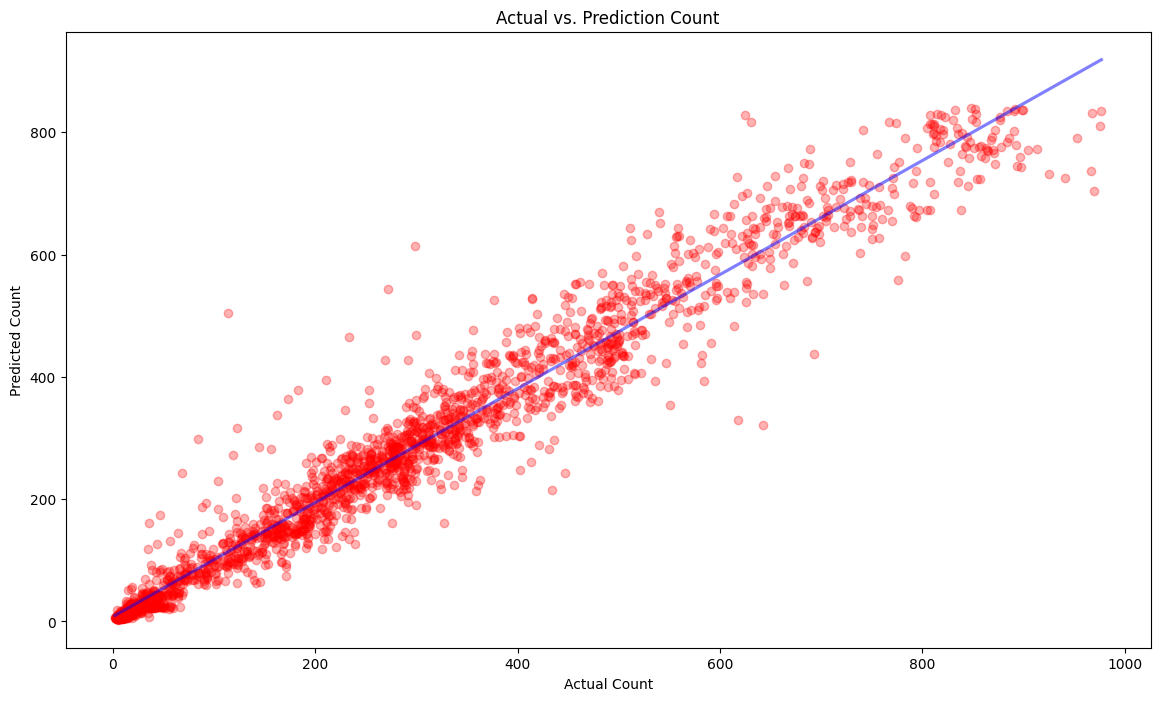

In [29]:
plt.figure(figsize=(14, 8))
sns.regplot(x=y_test, y=y_pred, ci=None, scatter_kws = {'color': 'red', 'alpha': 0.3}, line_kws = {'color': 'blue', 'alpha': 0.5}).set(title='Actual vs. Prediction Count', 
                                               xlabel='Actual Count', 
                                               ylabel='Predicted Count')
plt.show()

In [30]:
df_xgb = pd.DataFrame({
    'y_test' : y_test,
    'y_pred' : y_pred
})

df_xgb['residual'] = y_pred - y_test
df_xgb

,y_test,y_pred,residual
13128,149,124.483269,-24.516731
13129,93,98.785843,5.785843
13130,90,69.709610,-20.290390
13131,33,43.178566,10.178566
13132,4,10.172676,6.172676
...,...,...,...
15331,257,332.292480,75.292480
15332,194,190.783447,-3.216553
15333,123,146.881500,23.881500
15334,91,95.438248,4.438248


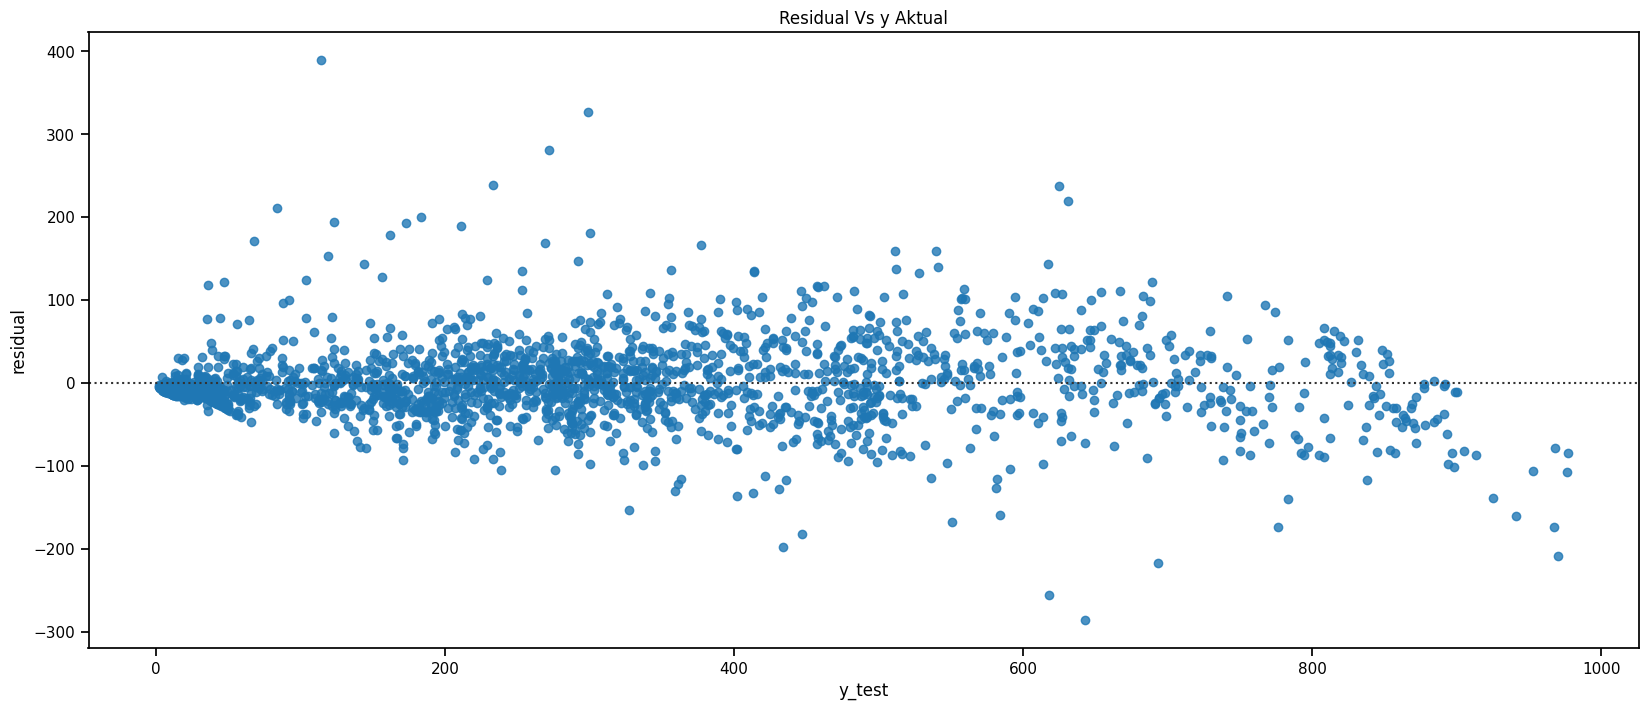

In [32]:
sns.set_context('notebook')
plt.figure(figsize=(20,8))
sns.residplot(x='y_test', y='residual', data=df_xgb).set(title='Residual Vs y Aktual')
plt.show()

In [33]:
dftarget = pd.DataFrame({'Actual Count': y_test, 'Predicted Count': y_pred})

df50 = dftarget[dftarget['Actual Count'] <=50]
df100 = dftarget[(dftarget['Actual Count']>50) & (dftarget['Actual Count']<=100)]
df150 = dftarget[(dftarget['Actual Count']>100) & (dftarget['Actual Count']<=150)]
df200 = dftarget[(dftarget['Actual Count']>150) & (dftarget['Actual Count']<=200)]
df250 = dftarget[(dftarget['Actual Count']>200) & (dftarget['Actual Count']<=250)]
df300 = dftarget[(dftarget['Actual Count']>250) & (dftarget['Actual Count']<=300)]
df350 = dftarget[(dftarget['Actual Count']>300) & (dftarget['Actual Count']<=350)]
df400 = dftarget[(dftarget['Actual Count']>350) & (dftarget['Actual Count']<=400)]
df450 = dftarget[(dftarget['Actual Count']>400) & (dftarget['Actual Count']<=450)]
df500 = dftarget[(dftarget['Actual Count']>450) & (dftarget['Actual Count']<=500)]
df550 = dftarget[(dftarget['Actual Count']>500) & (dftarget['Actual Count']<=550)]
df600 = dftarget[(dftarget['Actual Count']>550) & (dftarget['Actual Count']<=600)]
df600plus = dftarget[dftarget['Actual Count']>600]

target_range = [df50, df100, df150, df200, df250, df300, df350, df400, df450, df500, df550, df600, df600plus, dftarget]
index_range = ['<=50', '51-100', '101-150', '151-200', '201-250', '251-300', '301-350', '351-400', '401-450', '451-500', '501-550', '551-600', '>600', 'All Count Range (Max 953)']
mae = []
mape = []
for target in target_range:
    scoremae = mean_absolute_error(target['Actual Count'], target['Predicted Count'])
    scoremape = mean_absolute_percentage_error(target['Actual Count'], target['Predicted Count'])
    mae.append(scoremae)
    mape.append(scoremape)

range_metrics = pd.DataFrame({
              "Score MAE": mae,
              "Score MAPE": mape}, index=index_range)
range_metrics

,Score MAE,Score MAPE
<=50,7.848354,0.395776
51-100,20.830798,0.292163
101-150,29.415194,0.237544
151-200,30.122794,0.171705
201-250,30.455224,0.136019
251-300,31.555880,0.112893
301-350,31.234370,0.095879
351-400,40.002699,0.107670
401-450,51.614840,0.121546
451-500,46.895686,0.098298


#### **Predict Final Model on Unseen Data**

In [52]:
test_data = pd.read_csv('../data/processed/test.csv')
test_data

,dteday,month,dayofweek,hour,holiday,season,weather,temperature,humidity,count
0,2012-10-01,10,1,0,0,4,2,19.2,49,45
1,2012-10-01,10,1,1,0,4,1,17.2,61,18
2,2012-10-01,10,1,2,0,4,1,17.1,58,12
3,2012-10-01,10,1,3,0,4,1,16.4,63,7
4,2012-10-01,10,1,4,0,4,1,15.5,70,10
...,...,...,...,...,...,...,...,...,...,...
2203,2012-12-31,12,1,19,0,1,2,5.6,50,119
2204,2012-12-31,12,1,20,0,1,2,5.5,51,89
2205,2012-12-31,12,1,21,0,1,2,4.7,55,90
2206,2012-12-31,12,1,22,0,1,2,4.0,55,61


In [56]:
test_data['count_lag_1'] = test_data['count'].shift(1, fill_value=0)
test_data['workday'] = np.where((test_data['dayofweek'].isin([6,7]) | test_data['holiday']==1), 0, 1)
test_feature = test_data[['count_lag_1', 'hour', 'workday', 'dayofweek']]
test_target = test_data['count']

score_rmse = []
score_mae = []
score_mape = []

test_pred = models[i].predict(test_feature)
score_rmse.append(np.sqrt(mean_squared_error(test_target, test_pred)))
score_mae.append(mean_absolute_error(test_target, test_pred))
score_mape.append(mean_absolute_percentage_error(test_target, test_pred))

score_before_tuning = pd.DataFrame({'RMSE': score_rmse, 'MAE': score_mae, 'MAPE': score_mape}, index=['XGB'])
score_before_tuning

,RMSE,MAE,MAPE
XGB,46.089924,28.12,0.244388
